# Low-pass FIR Filter project
***

## Specification
***

1. Passband: $100Hz$
2. Max attenuation in passband: $1dB$
3. Stopband: $400Hz$
4. Min attenuation in stopband: $60dB$

### Start Point
***

Let's begin with a type I FIR. The response to this filter is shown below:

$$
h(n) = \frac{1}{M+1}\left\{2\sum_{k=1}^{\frac{M}{2}}(-1)^k|H(k)|\cos\left[\frac{\pi k(1 + 2n)}{M+1}\right] + H(0)\right\}
$$

Where M is the order of the filter. Let's start with M = 16 and see if the FIR fits the specification.

In [1]:
# Important imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fft_lib.fft import *
from scipy.signal.windows import kaiser
from scipy.fft import ifft

sns.set_theme()

Before we go further, I will use a Kaiser Window instead of the regular Rectangular window. I executed some tests with the regular window and I needed more than 1000 taps to achieve the specifications. So, the first step will be calculate the $\beta$ and the $M$

In [2]:
alfa = 60
passband = 100
stopband = 400
Fs = 2e3

beta = 0.1102*(alfa - 8.7)

M = int(np.round((alfa - 8)/(2.285*((stopband-passband)/(Fs/2)))) + 1)

In [3]:
# Important variables

N = M + 1
FFT_N = 1024
Wn = (stopband + passband)/2
max_attenuation_in_passband = 1
min_attenuation_in_stopband = -60
cuttof_frequency = Wn/(Fs/2)*np.pi

***
Let's take a break here to explain the Ideal response. Once $F_s = 2kHz$, the filter response must be a door function that goes from $0rad$ to $0.4\pi rad$ (This value is obtained by the correspondency of $F_s$ and $2\pi$ when calculating the DTFT). So, it must be something like this:
***

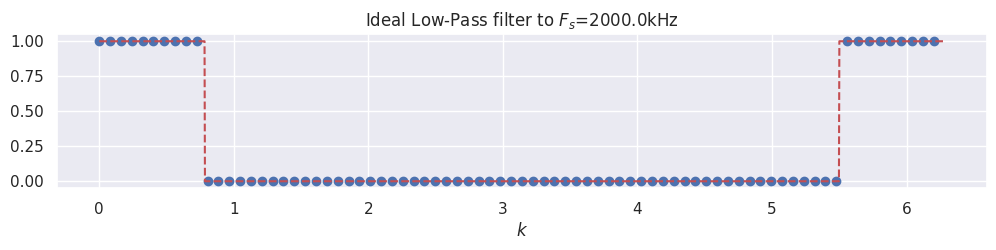

In [4]:
# Creating an array just to see the continous representation (DTFT)
k_dtft = np.linspace(0, 2*np.pi, 2000)
# Creating the array of the sampled representation (DFT)
k = np.arange(0, N)

# Creating the DTFT response
H_dtft = np.zeros(k_dtft.size)
cuttoff_point = np.where(np.isclose(k_dtft, cuttof_frequency, 1e-3))
H_dtft[k_dtft < k_dtft[cuttoff_point[0][0]]] = 1
H_dtft[k_dtft > (2*np.pi - k_dtft[cuttoff_point[0][0]])] = 1

# Creating the DFT response
H = np.zeros(k.size)
sampled_cuttof_frequency = int(np.floor(cuttof_frequency*M/(2*np.pi)))
cuttoff_point = np.where(k == sampled_cuttof_frequency)
H[k <= k[cuttoff_point[0]]] = 1
H[k >= k[-sampled_cuttof_frequency]] = 1


plt.figure(figsize=(12, 2))
plt.plot(k_dtft, H_dtft, '--r')
plt.scatter(k*2*np.pi/N, H)

plt.title(f'Ideal Low-Pass filter to $F_s$={Fs}kHz')
plt.xlabel('$k$')

plt.show()

Now we can start the process of modeling the FIR

In [5]:
def type_1_hn_calc(M, H):
    hn = np.zeros(M+1)
    n_array = np.arange(0, M+1)
    for n in range(M+1):
        for k in range(1, int(M/2)):
            hn[n] += ((-1)**k) * (np.abs(H[k])) * (np.cos(np.pi*k*(1 + 2*n)/(M+1)))
        hn[n] = (1/(M+1)) * (2*hn[n] + H[0])
    return n_array, hn
    

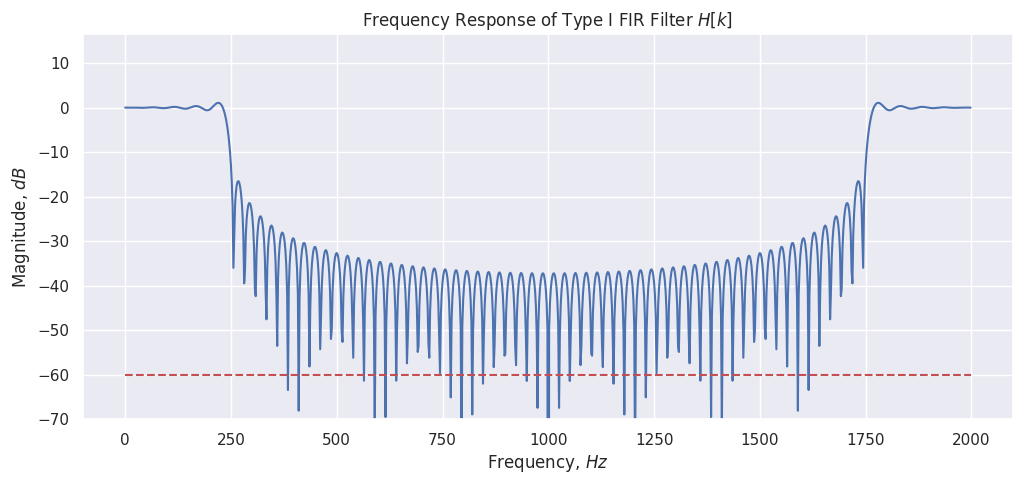

In [6]:
# Calculation of the h[n] response
(n, hn) = type_1_hn_calc(M, H)

# Calculation of frequency response H[k]
# Padding to match the FFT size
hn_padded = np.pad(hn, (0, FFT_N-N), 'constant')
my_fft = FFT(FFT_N)
Hk = my_fft.fft_calc(hn_padded)

k = np.arange(0, FFT_N)*Fs/FFT_N
mag = 20*np.log10(np.abs(Hk))

plt.figure(figsize=(12, 5))

plt.plot(k, mag)
plt.plot(k, k.size*[-60], '--r')
plt.ylim(-alfa - 10, )

plt.title(f'Frequency Response of Type I FIR Filter $H[k]$')
plt.xlabel(f'Frequency, $Hz$')
plt.ylabel(f'Magnitude, $dB$')
plt.show()

Now, the Kaiser window will be applied with the $\beta$ calculated at the beginning of this notebook

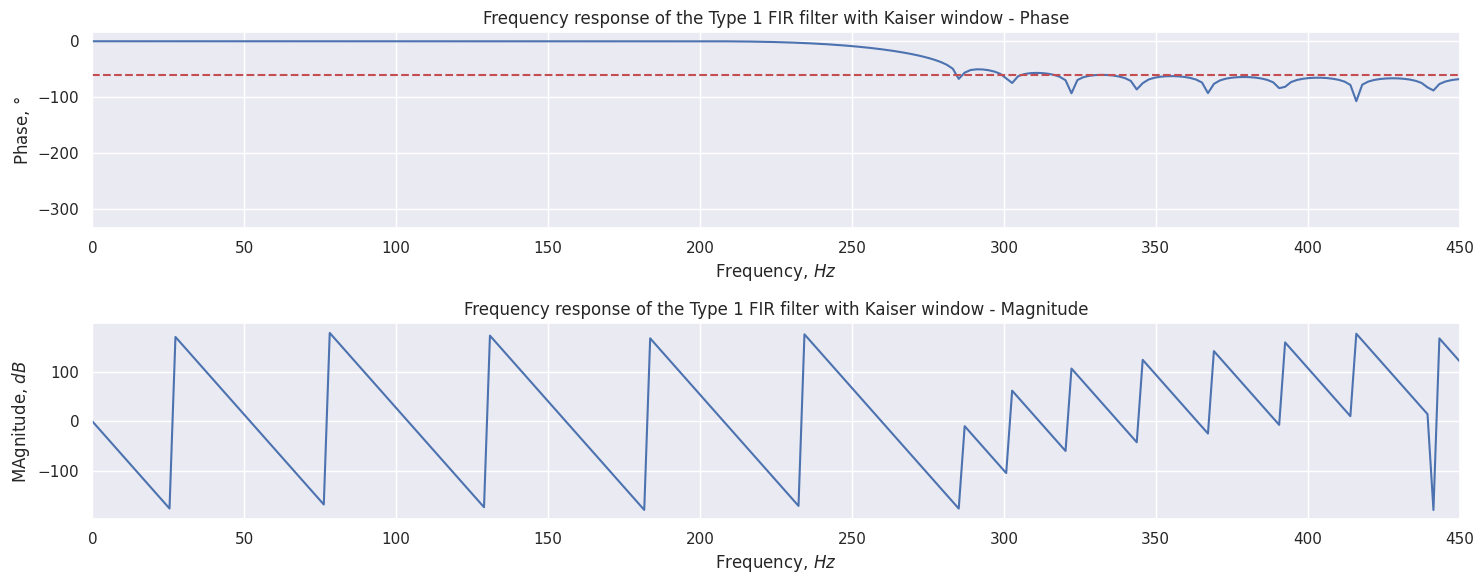

In [7]:
kaiser_window = kaiser(hn.size, beta)
hn_kaiser = hn*kaiser_window

hn_kaiser_padded = np.pad(hn_kaiser, (0, FFT_N-N), 'constant')

Hkaiser = my_fft.fft_calc(hn_kaiser_padded)

mag_kaiser = 20*np.log10(np.abs(Hkaiser))

angle_kaiser = np.angle(Hkaiser, deg=True)

plt.figure(figsize=(15, 6))

plt.subplot(2, 1, 1)
plt.plot(k, mag_kaiser)
plt.plot(k, k.size*[-60], '--r')
plt.xlim(0, 450)
plt.title("Frequency response of the Type 1 FIR filter with Kaiser window - Phase")
plt.xlabel("Frequency, $Hz$")
plt.ylabel("Phase, $°$")

plt.subplot(2, 1, 2)
plt.title("Frequency response of the Type 1 FIR filter with Kaiser window - Magnitude")
plt.xlabel("Frequency, $Hz$")
plt.ylabel("MAgnitude, $dB$")
plt.plot(k, angle_kaiser)
plt.xlim(0, 450)

plt.tight_layout()



Note that the phase is linear inside the passband

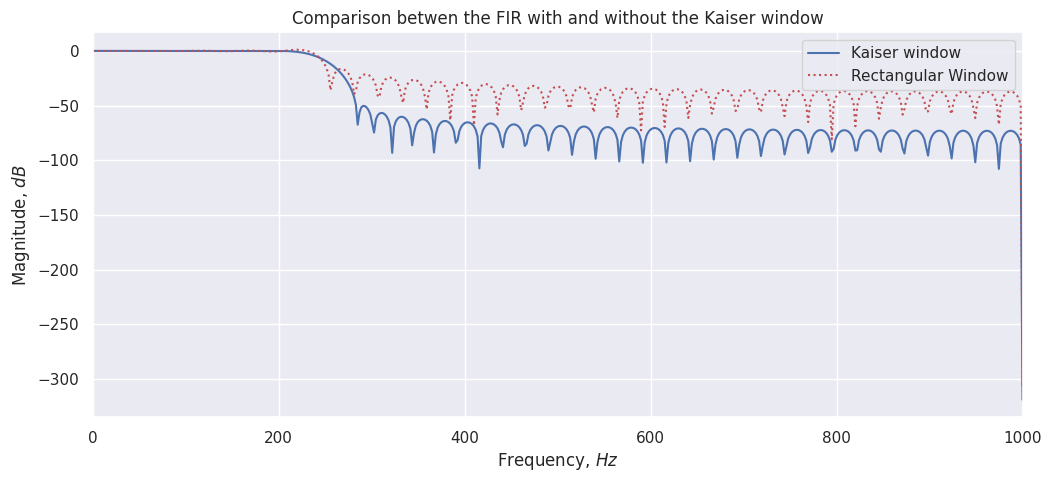

In [8]:
plt.figure(figsize=(12, 5))

plt.plot(k, mag_kaiser)
plt.plot(k, mag, ':r')
plt.xlim(0, 1000)
plt.title("Comparison betwen the FIR with and without the Kaiser window")
plt.xlabel("Frequency, $Hz$")
plt.ylabel("Magnitude, $dB$")
plt.legend(["Kaiser window", "Rectangular Window"])
plt.show()


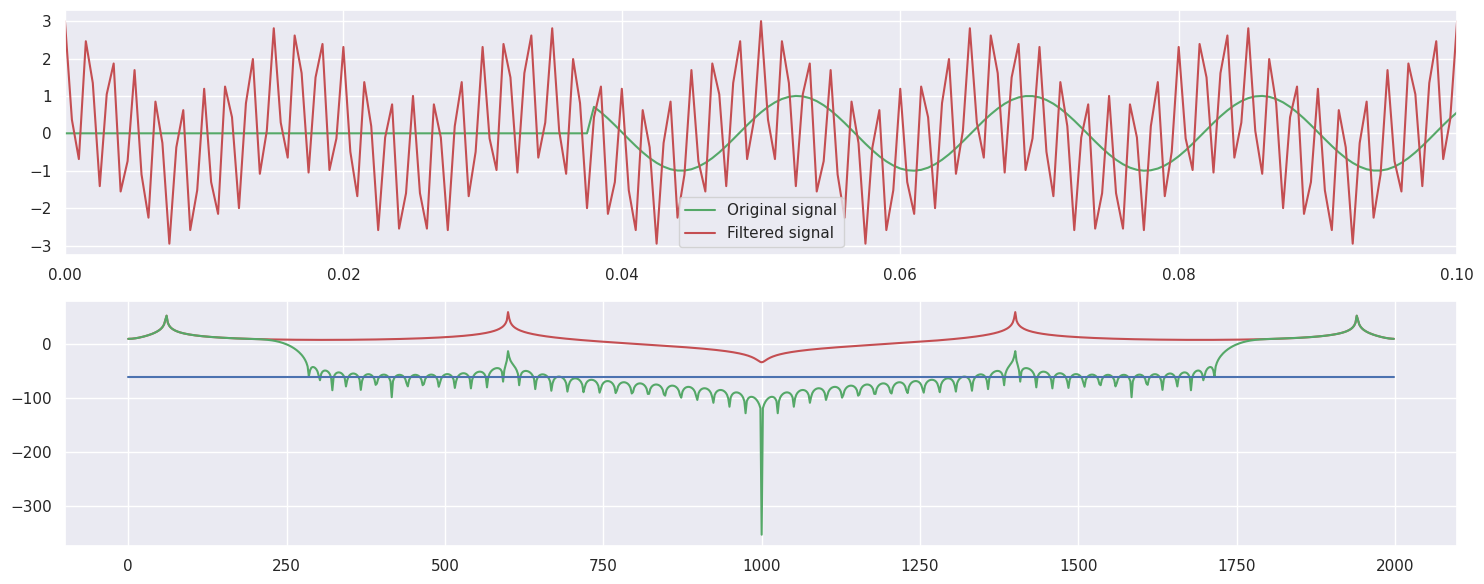

In [23]:
t = np.arange(0, (1024/Fs), step=(1/Fs))

y = np.cos(2*np.pi*60*t) + 2*np.cos(2*np.pi*600*t)

plt.figure(figsize=(15,6))

Y = my_fft.fft_calc(y)
Y = np.array(Y, dtype='complex')
Y_filtered = Y * Hkaiser
Y_filtered = np.array(Y_filtered, dtype='complex')

y_filtered = ifft(Y_filtered)
# Excludes transitory values
y_filtered[0:M-1] = 0

mag_y = 20*np.log10(np.abs(Y))
mag_y_filtered = 20*np.log10(np.abs(Y_filtered))

plt.subplot(2, 1, 1)
plt.plot(t, y_filtered.real, '-g')
plt.plot(t, y, '-r')
plt.xlim(0, 0.1)
plt.legend(["Original signal", "Filtered signal"])

plt.subplot(2 ,1 ,2)
plt.plot(k, mag_y, '-r')
plt.plot(k, mag_y_filtered, '-g')
plt.plot(k, k.size*[-60])


plt.tight_layout()
